## Load Trials Results (Dynamical Decoupling)

In [1]:
# Import the research library 
from benchmarklib import BenchmarkDatabase, CompileType

from sat import ThreeSat, ThreeSatTrial

import matplotlib.pyplot as plt

In [2]:
# Load Qiskit
from qiskit_ibm_runtime import QiskitRuntimeService, Batch
from dotenv import load_dotenv, find_dotenv
import os

load_dotenv()
API_TOKEN = os.getenv("API_TOKEN")
API_INSTANCE = os.getenv("API_INSTANCE", None)
service = QiskitRuntimeService(channel="ibm_cloud", token=API_TOKEN, instance=API_INSTANCE)
backend = service.backend(name="ibm_rensselaer")

In [3]:
# update db
import asyncio

db1 = BenchmarkDatabase("3SAT_copy.db", ThreeSat, ThreeSatTrial)
db2 = BenchmarkDatabase("3SAT_UP.db", ThreeSat, ThreeSatTrial)
await db2.update_all_pending_results(service)

## View Single Trial

In [6]:
trial_id = 2508
# xag
#trial_id = 2502
trial = db.get_trial(trial_id=trial_id)
problem = db.get_problem_instance(instance_id=trial.instance_id)
num_vars = problem.num_vars
compile_type = trial.compile_type
grover_iters = trial.trial_params['grover_iterations']
print(f'CNF : {problem.expr}')
print(f'{len(problem.solutions)} Solutions: {problem.solutions}')
print(f'Compile Type: {compile_type}')
print(f'{num_vars} Inputs')
print(f'{grover_iters} Grover Iterations')
print(f'Expected Success Rate {db.calculate_trial_expected_success_rate(trial)}%')
print(f'Success Rate {db.calculate_trial_success_rate(trial)}%')

CNF : [[4, 3, 2], [6, 3, 1], [4, -3, -5], [-2, -4, 6], [1, -2, -5], [2, 3, -4], [-5, 2, 6], [-3, -5, 1], [5, -3, 2], [2, 6, 3], [-3, 2, 5], [6, 2, 5], [1, 5, 6], [-2, -5, 3], [-4, 6, -2], [-1, 6, 4], [-1, -5, 4], [-4, -6, 3], [-2, -3, -1], [-6, -4, 1], [2, -3, -1], [-1, 3, -2], [2, 3, 6], [-1, -3, -4]]
2 Solutions: [[-1, 2, -3, -4, -5, 6], [-1, 2, 3, -4, -5, 6]]
Compile Type: CompileType.CLASSICAL_FUNCTION
6 Inputs
1 Grover Iterations
Expected Success Rate 0.2583007812500001%
Success Rate 0.022%


Circuit: 127q, depth=410, size=723, 2q_gates=121, est_error=100.0%, concerns=3


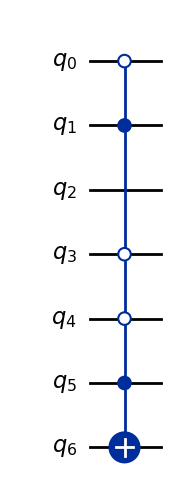

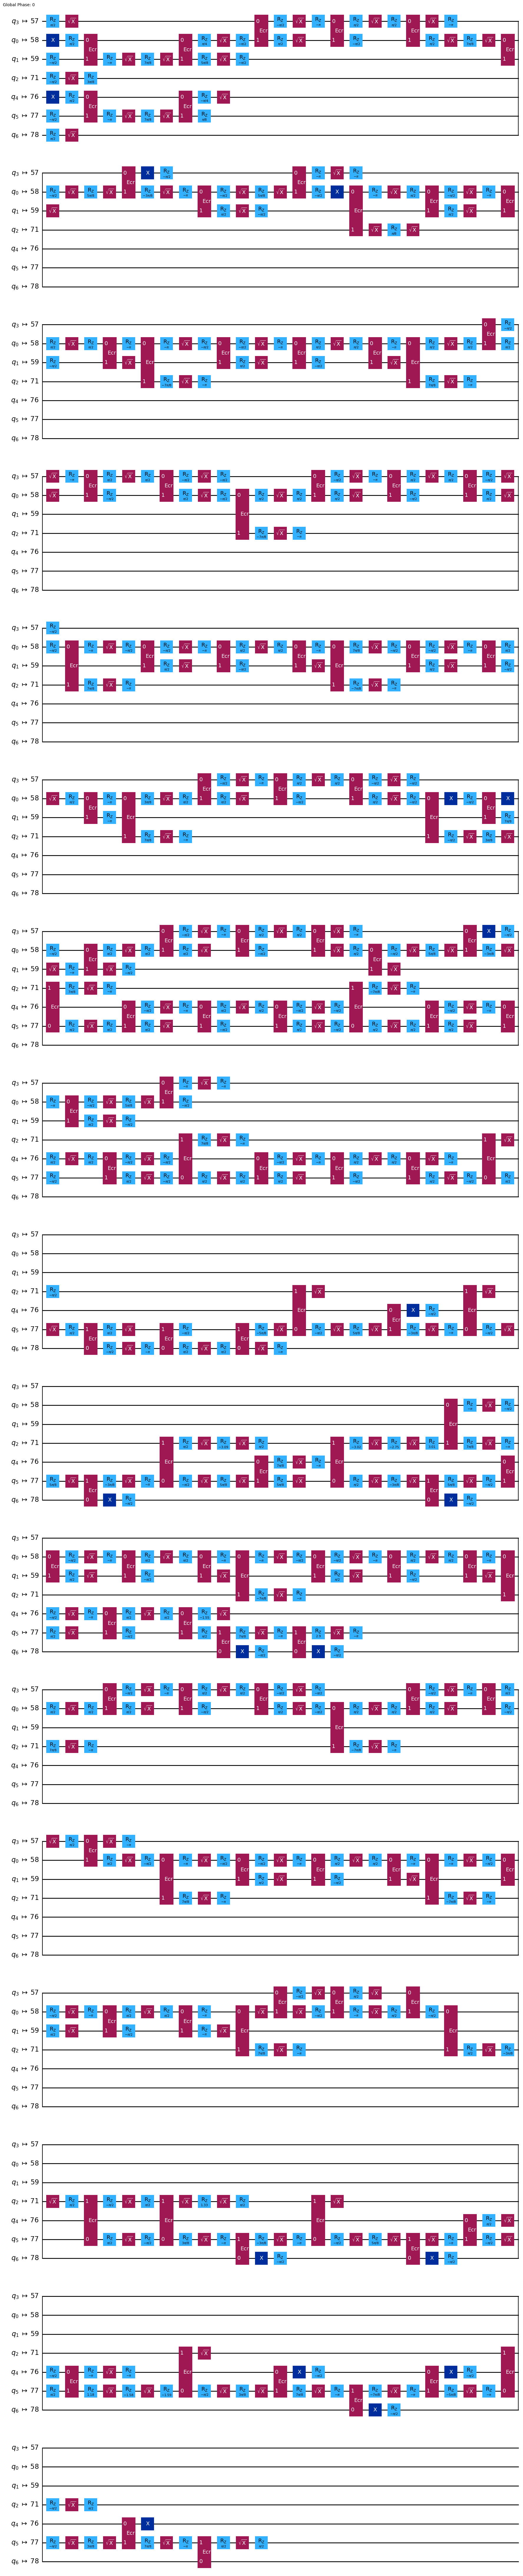

In [9]:
import qiskit
from typing import Dict, Any
from collections import Counter
from IPython.display import display # Import the display function
from qiskit import QuantumCircuit

def circuit_stats(qc: QuantumCircuit, verbose: bool = True) -> Dict[str, Any]:
    """
    Print basic statistics for a Qiskit QuantumCircuit.
    
    Args:
        qc: QuantumCircuit to analyze
        verbose: Print results to console
        
    Returns:
        Dictionary with circuit statistics
    """
    # Basic circuit properties
    stats = {
        'num_qubits': qc.num_qubits,
        'num_clbits': qc.num_clbits,
        'depth': qc.depth(),
        'size': qc.size(),  # Total number of gates
        'width': qc.width(),  # Total qubits + classical bits
    }
    
    # Gate composition
    gate_counts = Counter()
    two_qubit_gates = 0
    
    for instruction in qc.data:
        gate_name = instruction.operation.name
        gate_counts[gate_name] += 1
        
        # Count multi-qubit gates (potential noise sources)
        if len(instruction.qubits) >= 2:
            two_qubit_gates += 1
    
    stats['gate_counts'] = dict(gate_counts)
    stats['two_qubit_gates'] = two_qubit_gates
    stats['unique_gates'] = len(gate_counts)
    
    # Circuit complexity metrics
    stats['cx_count'] = gate_counts.get('cx', 0) + gate_counts.get('cnot', 0)
    stats['h_count'] = gate_counts.get('h', 0)
    stats['measurement_count'] = gate_counts.get('measure', 0)
    
    # Potential fidelity issues
    fidelity_concerns = []
    
    if stats['depth'] > 100:
        fidelity_concerns.append(f"High depth ({stats['depth']}) - gate errors accumulate")
    
    if stats['two_qubit_gates'] > 50:
        fidelity_concerns.append(f"Many 2-qubit gates ({stats['two_qubit_gates']}) - higher error rates")
    
    if stats['num_qubits'] > 20:
        fidelity_concerns.append(f"Large qubit count ({stats['num_qubits']}) - crosstalk, decoherence")
    
    if 'reset' in gate_counts:
        fidelity_concerns.append("Reset operations present - may increase noise")
    
    if stats['cx_count'] / stats['size'] > 0.3 if stats['size'] > 0 else False:
        fidelity_concerns.append(f"High CNOT density ({stats['cx_count']}/{stats['size']} = {stats['cx_count']/stats['size']:.2f})")
    
    stats['fidelity_concerns'] = fidelity_concerns
    
    # Calculate approximate error rate (rough estimate)
    # Typical single-qubit error ~0.1%, two-qubit error ~0.5-1%
    single_qubit_ops = stats['size'] - stats['two_qubit_gates']
    approx_error_rate = (single_qubit_ops * 0.001) + (stats['two_qubit_gates'] * 0.007)
    stats['approx_cumulative_error'] = min(1.0, approx_error_rate)
    
    if verbose:
        print(f"Circuit Statistics:")
        print(f"  Qubits: {stats['num_qubits']}, Classical bits: {stats['num_clbits']}")
        print(f"  Depth: {stats['depth']}, Size: {stats['size']} gates")
        print(f"  Two-qubit gates: {stats['two_qubit_gates']}")
        print(f"  CNOT count: {stats['cx_count']}")
        print(f"  Approx. cumulative error: {stats['approx_cumulative_error']:.1%}")
        
        if stats['gate_counts']:
            print(f"  Gate composition: {dict(list(stats['gate_counts'].items())[:5])}")
            if len(stats['gate_counts']) > 5:
                print(f"    ... and {len(stats['gate_counts'])-5} more gate types")
        
        if fidelity_concerns:
            print(f"  ⚠️  Potential fidelity issues:")
            for concern in fidelity_concerns:
                print(f"    - {concern}")
        else:
            print(f"  ✓ No obvious fidelity concerns detected")
    
    return stats


# Convenience function for quick analysis
def quick_circuit_check(qc: QuantumCircuit) -> None:
    """Quick one-line circuit summary."""
    stats = circuit_stats(qc, verbose=False)
    concerns = len(stats['fidelity_concerns'])
    print(f"Circuit: {stats['num_qubits']}q, depth={stats['depth']}, "
          f"size={stats['size']}, 2q_gates={stats['two_qubit_gates']}, "
          f"est_error={stats['approx_cumulative_error']:.1%}, "
          f"concerns={concerns}")

oracle = problem.oracle(compile_type=compile_type)
rpi_qc = qiskit.transpile(oracle, backend=backend, optimization_level=3)
quick_circuit_check(rpi_qc)

display(oracle.draw('mpl'))
display(rpi_qc.draw('mpl'))

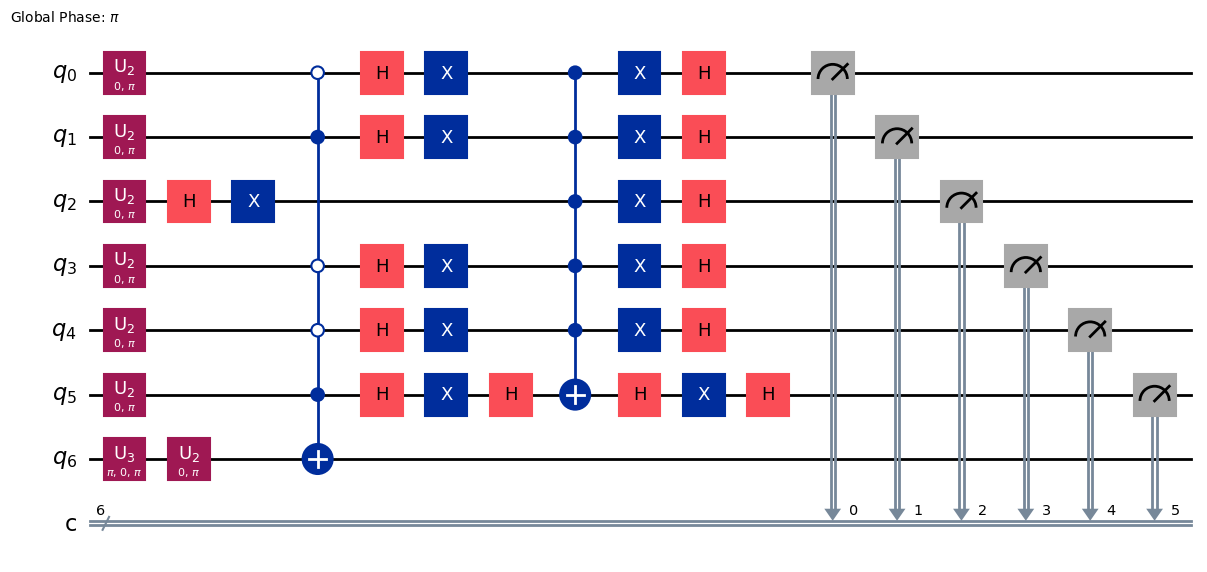

In [10]:
import qiskit
from qiskit.circuit.library import grover_operator
from qiskit_aer import AerSimulator

def build_grover_circuit(oracle: qiskit.QuantumCircuit, num_vars: int, grover_iterations: int) -> qiskit.QuantumCircuit:
        # Build Grover operator
        grover_op = grover_operator(oracle, reflection_qubits=range(num_vars))

        # Create search circuit
        search_circuit = qiskit.QuantumCircuit(oracle.num_qubits, num_vars)

        # Initialize ancilla for Uf mode
        search_circuit.x(num_vars)
        search_circuit.h(num_vars)

        # Initialize superposition
        search_circuit.h(range(num_vars))

        # Apply Grover operator
        if grover_iterations > 0:
            search_circuit.compose(grover_op.power(grover_iterations), inplace=True)

        # Measure
        search_circuit.measure(range(num_vars), range(num_vars))

        return search_circuit

grover = build_grover_circuit(oracle, num_vars, grover_iters)

grover = grover.decompose()

display(grover.draw('mpl'))

In [ ]:
from typing import Optional, Dict

def run_simulation(circuit: qiskit.QuantumCircuit) -> Optional[Dict[str, int]]:
    simulator = AerSimulator()
    
    try:
        # Transpile for simulator
        qc = qiskit.transpile(
            circuit,
            simulator,
            optimization_level=3,
        )

        # Run simulation
        result = simulator.run(qc, shots=10**4).result()
        counts = result.get_counts()

        print(f"Simulation completed: {len(counts)} unique outcomes")
        return counts

    except Exception as e:
        print(f"Simulation failed: {e}")
        return None

def run_on_qc(circuit: QuantumCircuit) -> Optional[Dict[str, int]]:
    from qiskit_ibm_runtime import Sampler
    sampler = Sampler(backend)
    qc = qiskit.transpile(circuit, backend=backend, optimization_level=3)
    job = sampler.run([qc], shots=10**4)
    print(job.job_id())
    return job

sim_counts = run_simulation(circuit=grover)
job = run_on_qc(circuit=grover)
#result = job.result()
#hw_counts = result[0].data.c.get_counts()

In [ ]:
success_rate = hw_counts['011']/sum(hw_counts.values())
expected_success_rate = sim_counts['011']/sum(hw_counts.values())
print(f'Success Rate / Expected = {success_rate/expected_success_rate}')

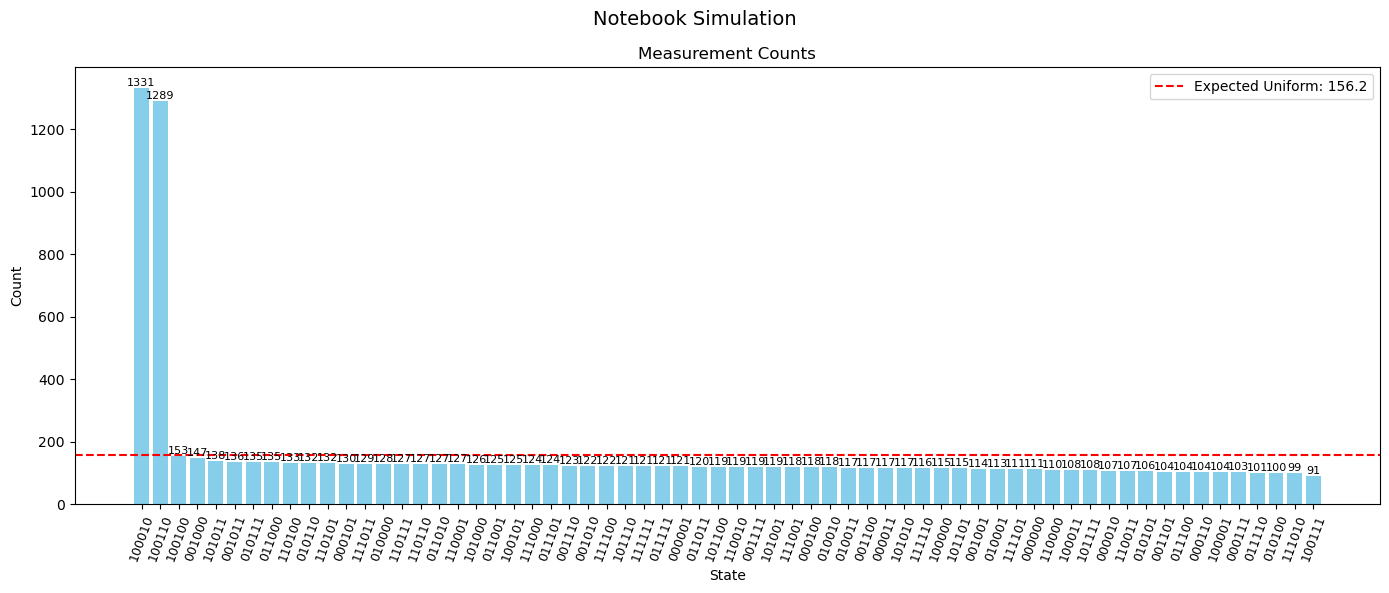

Total samples: 10000
Highest state: 100010 (1331 counts, 13.31%)
Lowest state: 100111 (91 counts, 0.91%)
⚠ No clear winner detected. Top state has only 13.3% probability


{'total_samples': 10000, 'top_state': '100010', 'top_probability': 0.1331}

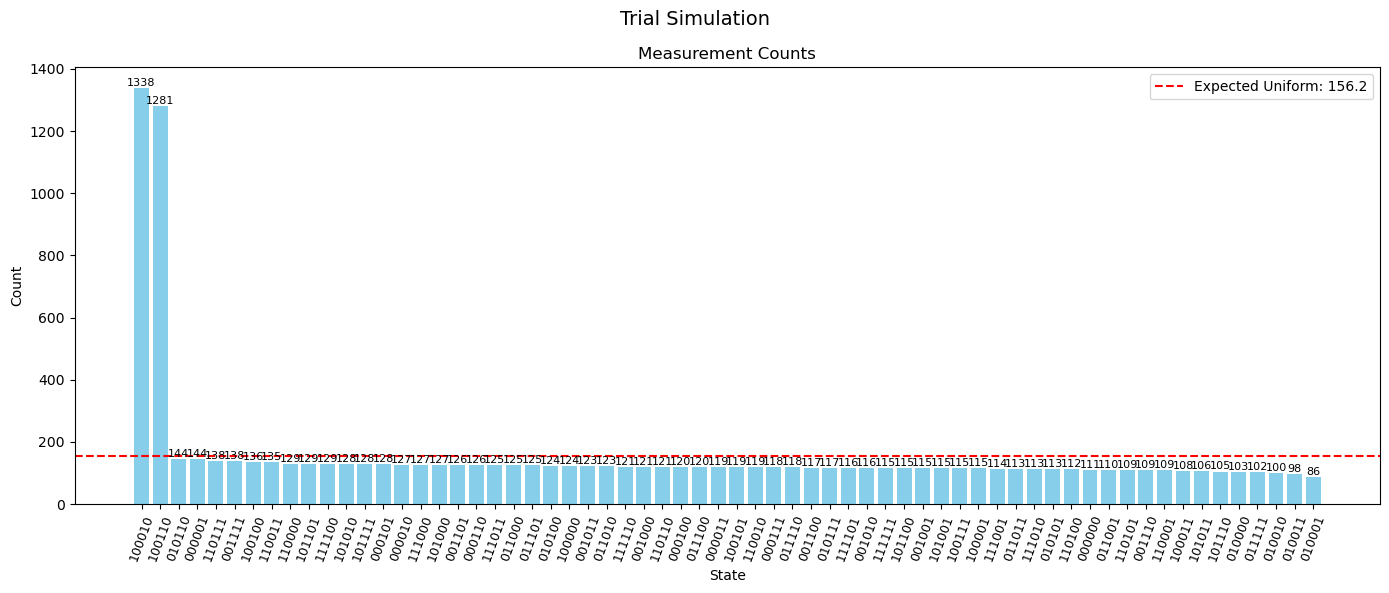

Total samples: 10000
Highest state: 100010 (1338 counts, 13.38%)
Lowest state: 010001 (86 counts, 0.86%)
⚠ No clear winner detected. Top state has only 13.4% probability


{'total_samples': 10000, 'top_state': '100010', 'top_probability': 0.1338}

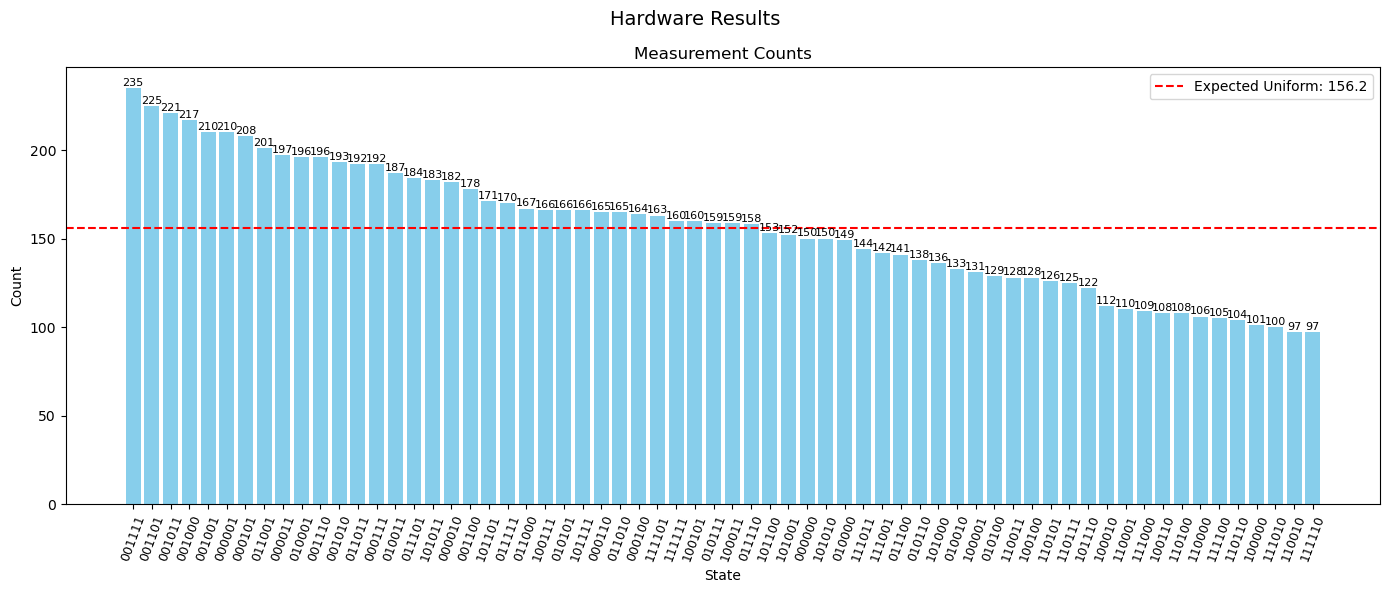

Total samples: 10000
Highest state: 001111 (235 counts, 2.35%)
Lowest state: 111110 (97 counts, 0.97%)
⚠ No clear winner detected. Top state has only 2.4% probability
⚠ Distribution appears close to uniform (max variation: 0.8%)


{'total_samples': 10000, 'top_state': '001111', 'top_probability': 0.0235}

In [12]:
import matplotlib.pyplot as plt
import numpy as np

def simple_visualize_results(results_dict, title="Quantum Measurement Results"):
    # Basic calculations
    total_samples = sum(results_dict.values())
    n_qubits = len(list(results_dict.keys())[0])
    
    # Sort results by count (descending)
    sorted_results = dict(sorted(results_dict.items(), key=lambda x: x[1], reverse=True))
    
    # Create figure with two subplots
    fig, ax1 = plt.subplots(figsize=(14, 6))
    
    # 1. Bar chart of states
    bars = ax1.bar(range(len(sorted_results)), sorted_results.values(), color='skyblue')
    
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{int(height)}', ha='center', va='bottom', fontsize=8)
    
    # Set the x-tick positions and labels
    ax1.set_xticks(range(len(sorted_results)))
    ax1.set_xticklabels(list(sorted_results.keys()), rotation=70, fontsize=9)
    
    # Add uniform expectation line
    expected_uniform = total_samples / len(results_dict)
    ax1.axhline(y=expected_uniform, color='red', linestyle='--', 
                label=f'Expected Uniform: {expected_uniform:.1f}')
    
    ax1.set_title('Measurement Counts')
    ax1.set_xlabel('State')
    ax1.set_ylabel('Count')
    ax1.legend()
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print simple statistics
    print(f"Total samples: {total_samples}")
    print(f"Highest state: {list(sorted_results.keys())[0]} ({list(sorted_results.values())[0]} counts, {list(sorted_results.values())[0]/total_samples*100:.2f}%)")
    print(f"Lowest state: {list(sorted_results.keys())[-1]} ({list(sorted_results.values())[-1]} counts, {list(sorted_results.values())[-1]/total_samples*100:.2f}%)")
    
    # Check for clear winner (probability > 20%)
    top_prob = list(sorted_results.values())[0] / total_samples
    if top_prob > 0.2:
        print(f"✓ Strong signal detected in state {list(sorted_results.keys())[0]} ({top_prob*100:.1f}%)")
    else:
        print(f"⚠ No clear winner detected. Top state has only {top_prob*100:.1f}% probability")
    
    # Check for uniformity
    uniformity_threshold = 0.05  # 5% variation
    max_variation = max(abs(count/total_samples - 1/len(results_dict)) for count in results_dict.values())
    
    if max_variation < uniformity_threshold:
        print(f"⚠ Distribution appears close to uniform (max variation: {max_variation*100:.1f}%)")
    
    # Return a simple summary for programmatic use
    return {
        "total_samples": total_samples,
        "top_state": list(sorted_results.keys())[0],
        "top_probability": top_prob,
    }

# from this notebook
display(simple_visualize_results(sim_counts, "Notebook Simulation"))
#display(simple_visualize_results(hw_counts, "Notebook HW Results"))

# from the trial
display(simple_visualize_results(trial.simulation_counts, "Trial Simulation"))
display(simple_visualize_results(trial.counts, "Hardware Results"))

## Plot

Analyzing 3SAT problems:
  Total instances: 2400
  Total trials: 948
  Completed trials: 944

(n, grover_iterations) = (3, 1) 	 (16 trials)
Mean success rate: 0.6366
Mean success rate: 0.8906
Mean success rate over expected: 0.7109
(n, grover_iterations) = (3, 2) 	 (3 trials)
Mean success rate: 0.3226
Mean success rate: 0.7813
Mean success rate over expected: 0.4129
(n, grover_iterations) = (4, 1) 	 (19 trials)
Mean success rate: 0.2267
Mean success rate: 0.8382
Mean success rate over expected: 0.2601
(n, grover_iterations) = (4, 2) 	 (8 trials)
Mean success rate: 0.1282
Mean success rate: 0.6655
Mean success rate over expected: 0.1841
(n, grover_iterations) = (4, 3) 	 (3 trials)
Mean success rate: 0.0729
Mean success rate: 0.4727
Mean success rate over expected: 0.1542
(n, grover_iterations) = (5, 1) 	 (20 trials)
Mean success rate: 0.1380
Mean success rate: 0.7440
Mean success rate over expected: 0.1756
(n, grover_iterations) = (5, 2) 	 (12 trials)
Mean success rate: 0.0962
Mean succ

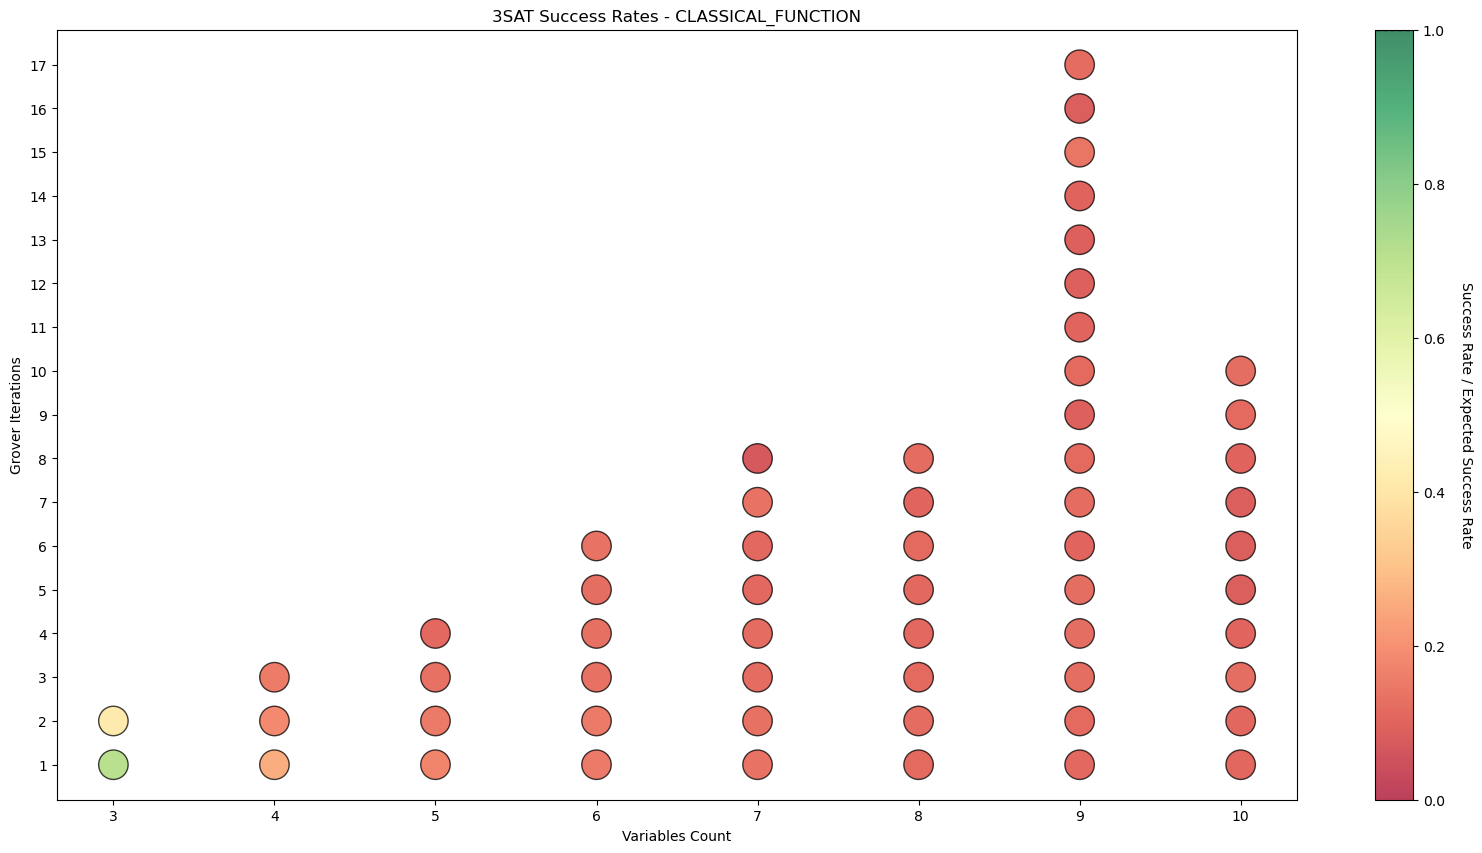

(n, grover_iterations) = (3, 1) 	 (16 trials)
Mean success rate: 0.5484
Mean success rate: 0.8906
Mean success rate over expected: 0.6082
(n, grover_iterations) = (3, 2) 	 (3 trials)
Mean success rate: 0.2316
Mean success rate: 0.7813
Mean success rate over expected: 0.2965
(n, grover_iterations) = (4, 1) 	 (19 trials)
Mean success rate: 0.1949
Mean success rate: 0.8382
Mean success rate over expected: 0.2241
(n, grover_iterations) = (4, 2) 	 (8 trials)
Mean success rate: 0.1143
Mean success rate: 0.6655
Mean success rate over expected: 0.1705
(n, grover_iterations) = (4, 3) 	 (3 trials)
Mean success rate: 0.0673
Mean success rate: 0.4727
Mean success rate over expected: 0.1425
(n, grover_iterations) = (5, 1) 	 (20 trials)
Mean success rate: 0.1359
Mean success rate: 0.7440
Mean success rate over expected: 0.1737
(n, grover_iterations) = (5, 2) 	 (12 trials)
Mean success rate: 0.0957
Mean success rate: 0.6233
Mean success rate over expected: 0.1487
(n, grover_iterations) = (5, 3) 	 (3 

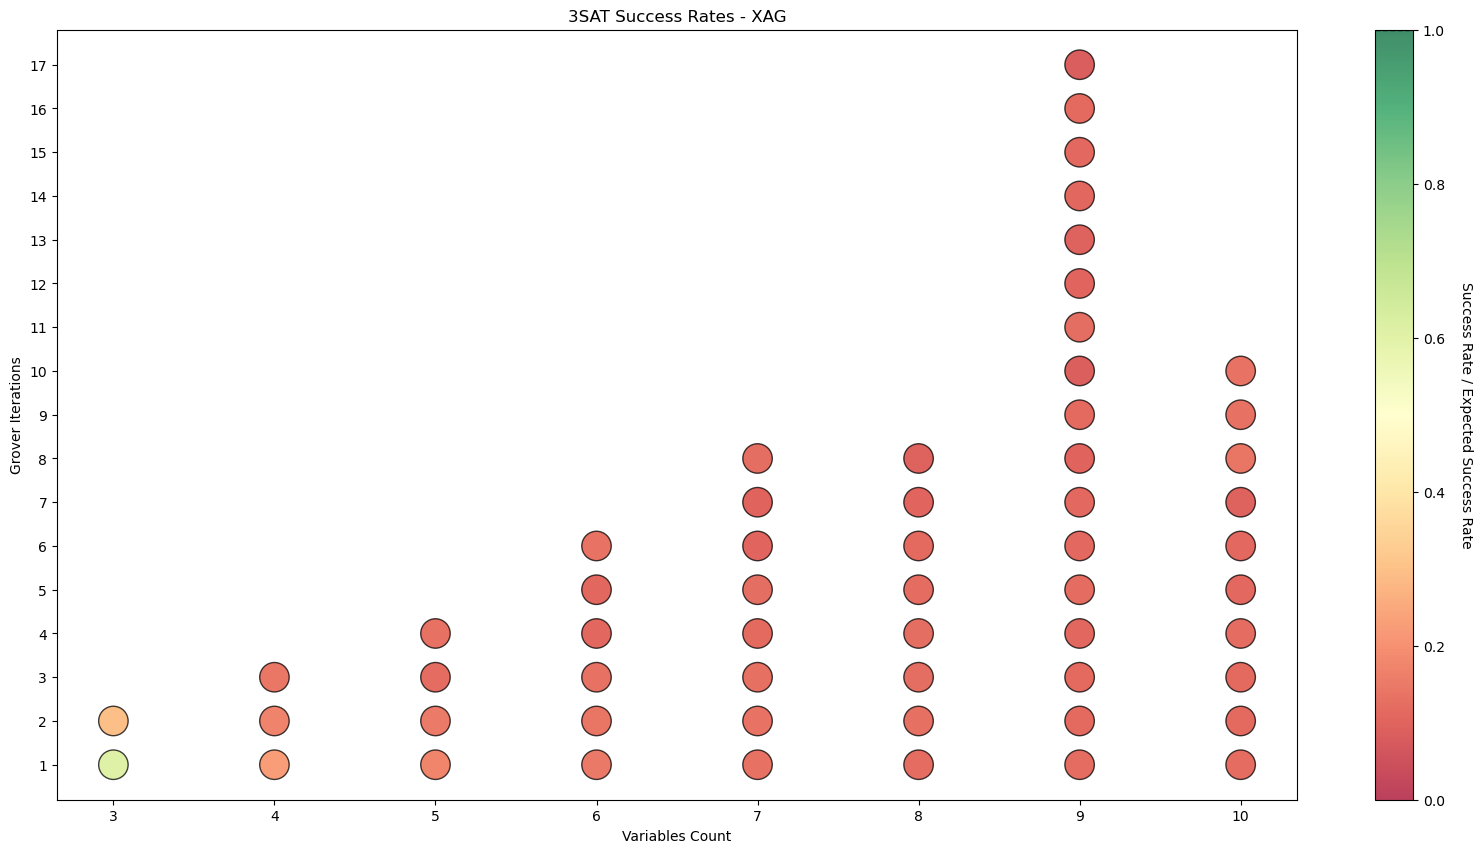

In [3]:
from benchmarklib.analysis import analyze_success_rates, analyze_fidelity

save_dir = "plots"
analyze_success_rates(db, [CompileType.CLASSICAL_FUNCTION, CompileType.XAG], save_dir=save_dir)

Quantum Advantage Analysis for 3SAT problems:
  Total instances: 2400
  Total trials: 948
  Completed trials: 944


=== Analyzing XAG ===
(n, grover_iterations) = (3, 1) 	 (16 trials)
Average P_m: 0.5484
Expected oracle calls (noisy): 1.82
Classical oracle calls: 8.00
Theoretical optimal oracle calls: 2.22
Grover iterations used: 1 (vs optimal: 2.2, ratio: 0.45)
Break-even probability threshold: 0.2777
Quantum advantage: YES

(n, grover_iterations) = (3, 2) 	 (3 trials)
Average P_m: 0.2316
Expected oracle calls (noisy): 8.63
Classical oracle calls: 8.00
Theoretical optimal oracle calls: 2.22
Grover iterations used: 2 (vs optimal: 2.2, ratio: 0.90)
Break-even probability threshold: 0.2777
Quantum advantage: NO

(n, grover_iterations) = (4, 1) 	 (19 trials)
Average P_m: 0.1949
Expected oracle calls (noisy): 5.13
Classical oracle calls: 8.00
Theoretical optimal oracle calls: 2.22
Grover iterations used: 1 (vs optimal: 2.2, ratio: 0.45)
Break-even probability threshold: 0.2777
Quantum adva

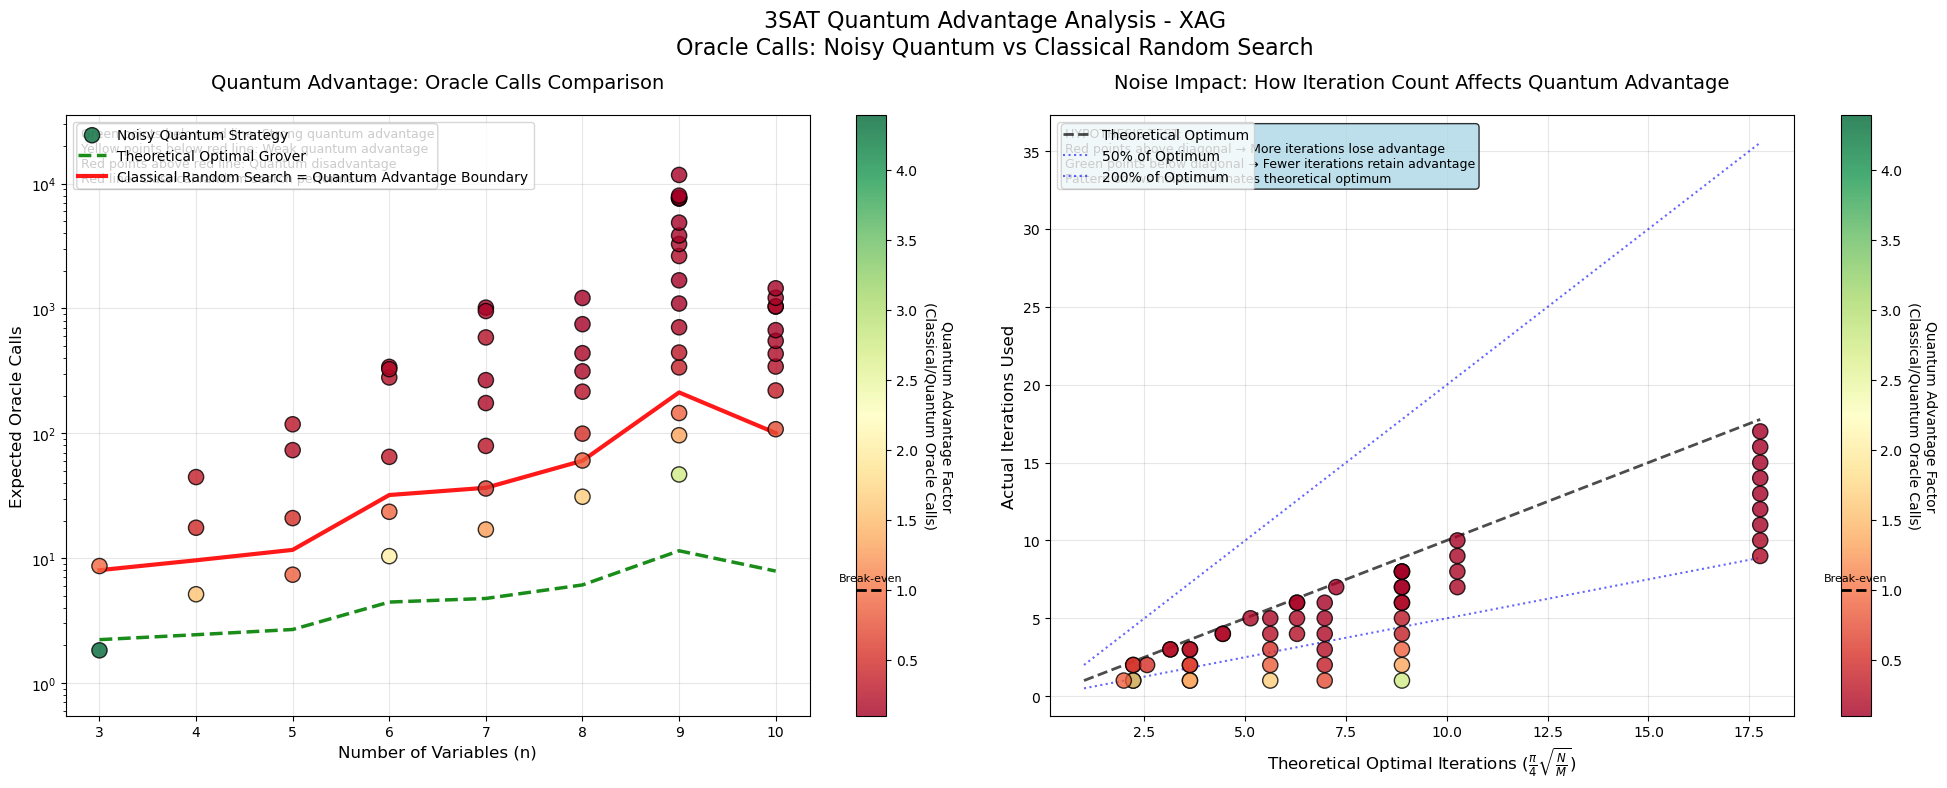


Summary for XAG:
  ✓ Quantum Advantage Analysis:
    - Points with quantum advantage: 7/58 (12.1%)
    - Average success probability: 0.0401
    - Success probability range: 0.0014 - 0.5484
  ✓ Grover Iterations Analysis:
    - Well-optimized iterations (±20%): 22/58 (37.9%)
    - Average iteration ratio (actual/optimal): 0.68
    - Iteration ratio range: 0.11 - 0.97
    - Points losing advantage due to poor iteration choice: 29
      → Consider optimizing Grover iteration counts!

=== Analyzing CLASSICAL_FUNCTION ===
(n, grover_iterations) = (3, 1) 	 (16 trials)
Average P_m: 0.6366
Expected oracle calls (noisy): 1.57
Classical oracle calls: 8.00
Theoretical optimal oracle calls: 2.22
Grover iterations used: 1 (vs optimal: 2.2, ratio: 0.45)
Break-even probability threshold: 0.2777
Quantum advantage: YES

(n, grover_iterations) = (3, 2) 	 (3 trials)
Average P_m: 0.3226
Expected oracle calls (noisy): 6.20
Classical oracle calls: 8.00
Theoretical optimal oracle calls: 2.22
Grover iterati

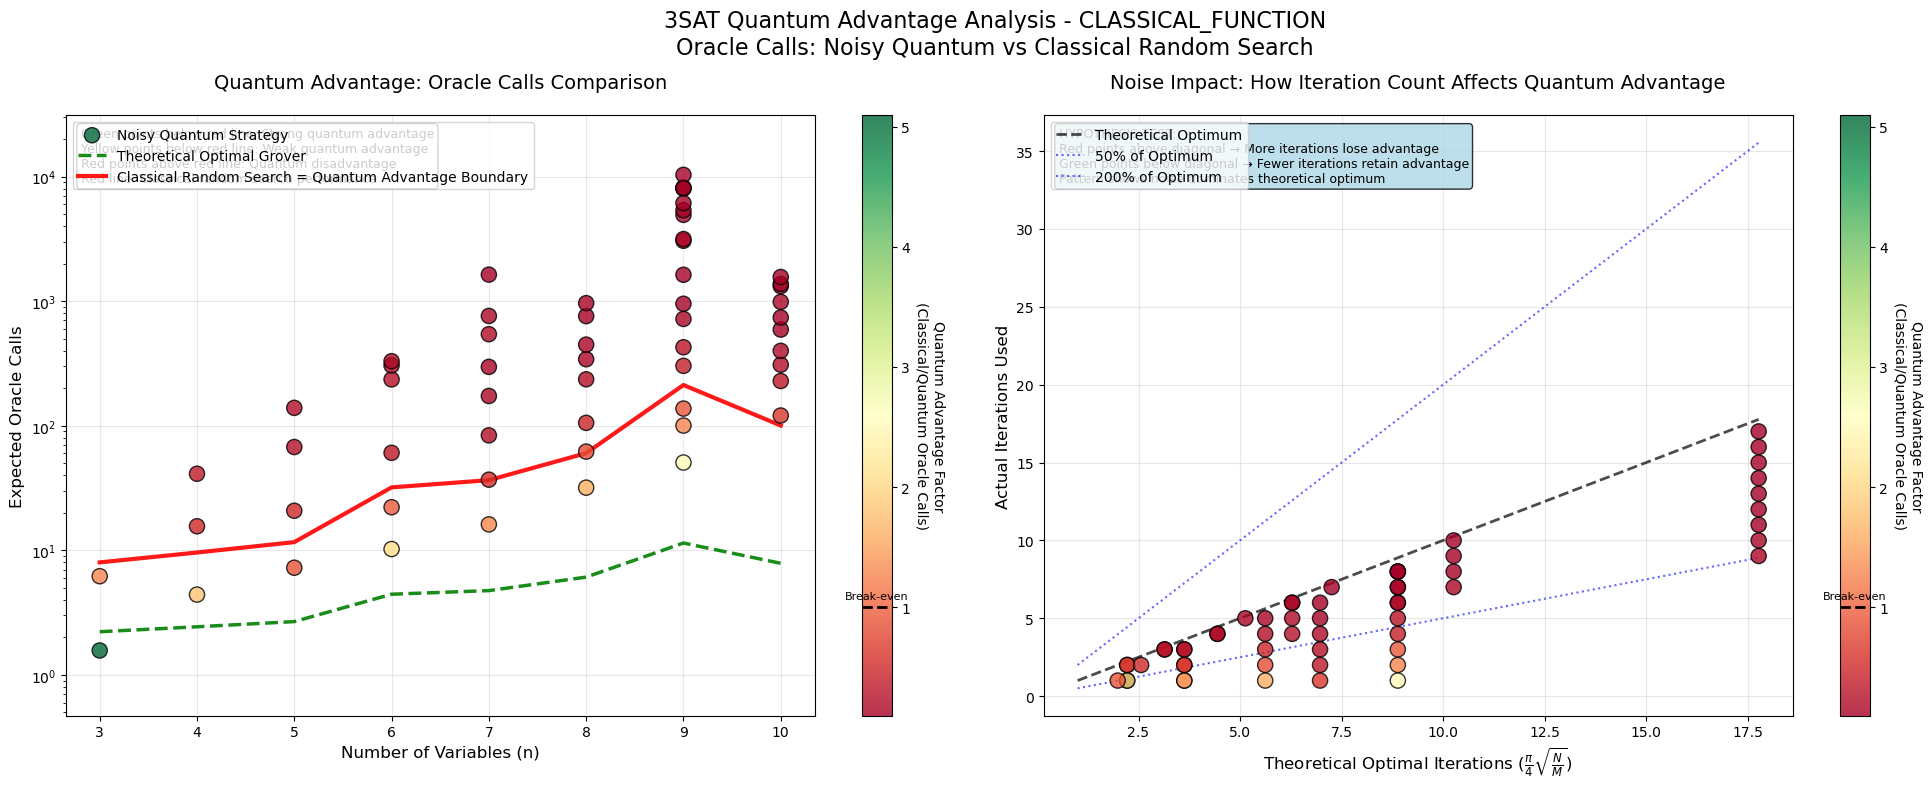


Summary for CLASSICAL_FUNCTION:
  ✓ Quantum Advantage Analysis:
    - Points with quantum advantage: 8/58 (13.8%)
    - Average success probability: 0.0442
    - Success probability range: 0.0015 - 0.6366
  ✓ Grover Iterations Analysis:
    - Well-optimized iterations (±20%): 22/58 (37.9%)
    - Average iteration ratio (actual/optimal): 0.68
    - Iteration ratio range: 0.11 - 0.97
    - Points losing advantage due to poor iteration choice: 29
      → Consider optimizing Grover iteration counts!
(n, grover_iterations) = (3, 1) 	 (16 trials)
Average P_m: 0.5484
Expected oracle calls (noisy): 1.82
Classical oracle calls: 8.00
Theoretical optimal oracle calls: 2.22
Grover iterations used: 1 (vs optimal: 2.2, ratio: 0.45)
Break-even probability threshold: 0.2777
Quantum advantage: YES

(n, grover_iterations) = (3, 2) 	 (3 trials)
Average P_m: 0.2316
Expected oracle calls (noisy): 8.63
Classical oracle calls: 8.00
Theoretical optimal oracle calls: 2.22
Grover iterations used: 2 (vs optimal

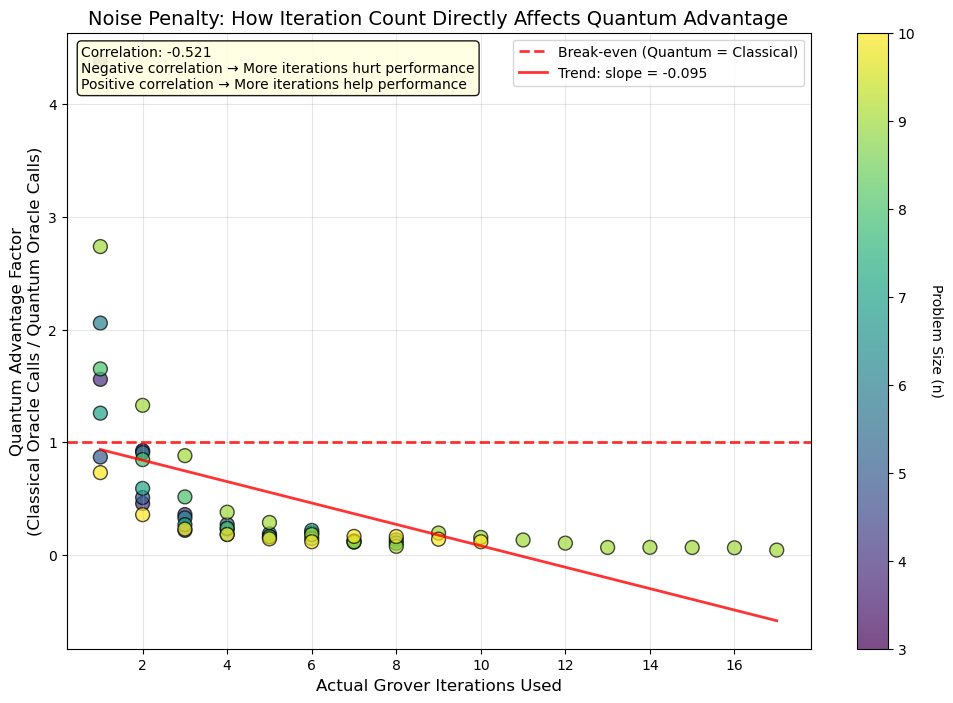

NameError: name 'plot_iteration_efficiency_heatmap' is not defined

In [4]:
from benchmarklib.analysis import *

analyze_quantum_advantage(db, save_dir="./plots")

# Direct correlation test
plot_noise_penalty_analysis(db, CompileType.XAG, "noise_penalty.png")

# 2D landscape view  
plot_iteration_efficiency_heatmap(db, CompileType.XAG, "heatmap.png")

Enhanced Fidelity Analysis for 3SAT problems:
  Total instances: 2400
  Completed trials: 944



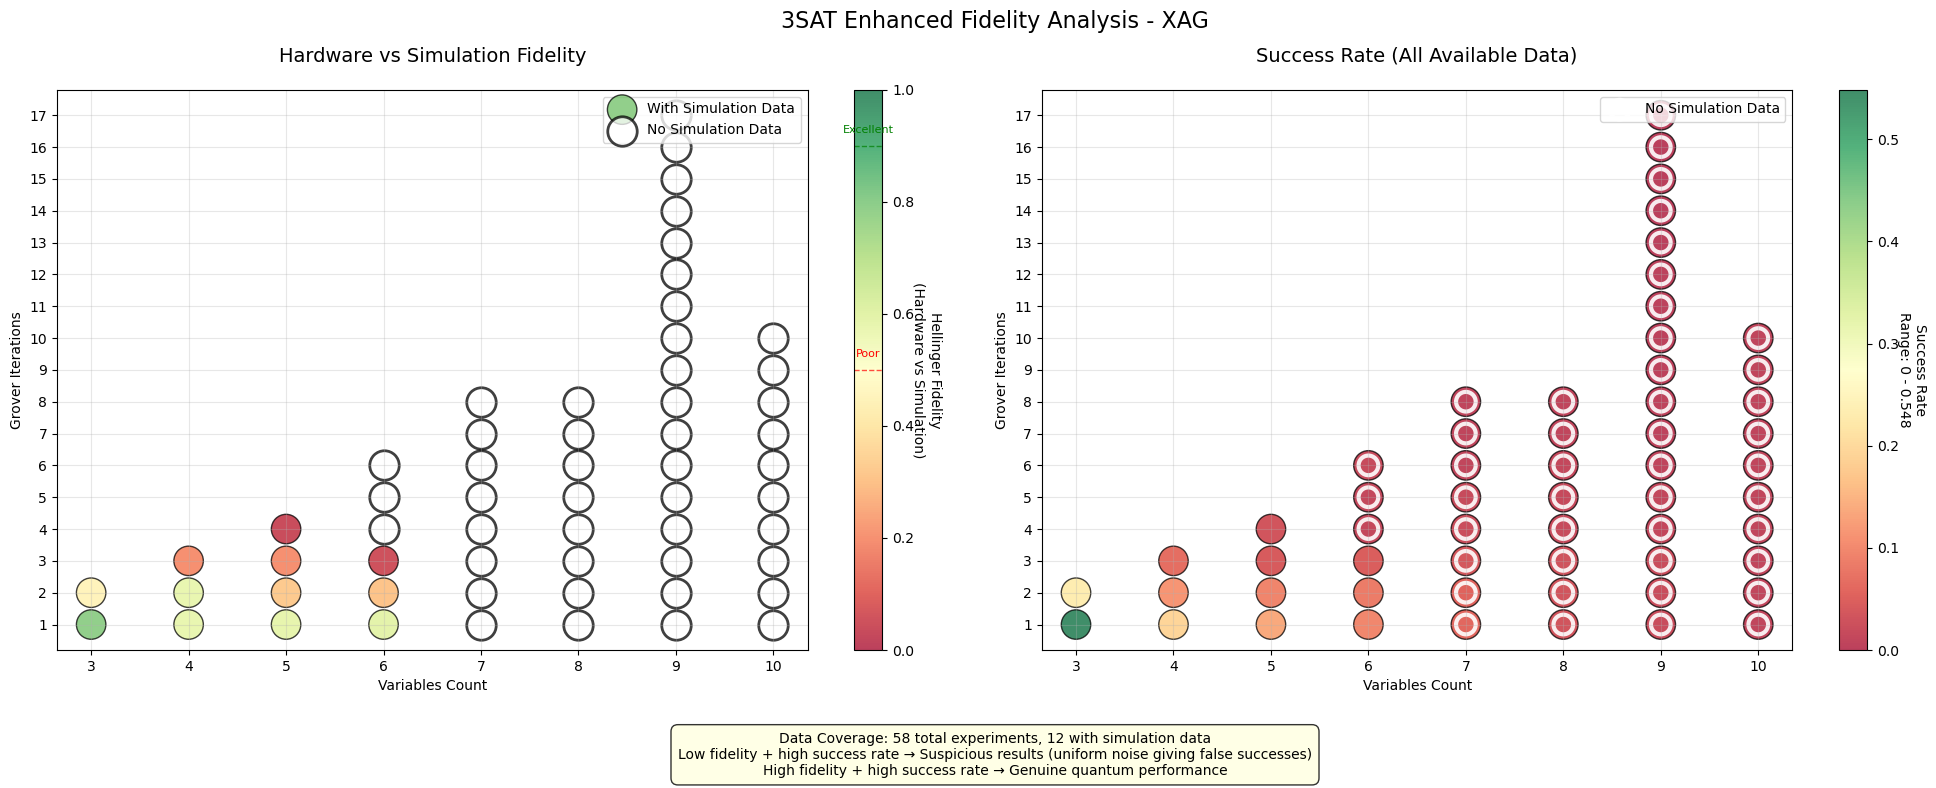


Detailed Analysis for XAG:
  Total data points: 58
  Points with simulation data: 12 (20.7%)
  Average success rate (all points): 0.0401
  Average fidelity (sim available): 0.3901


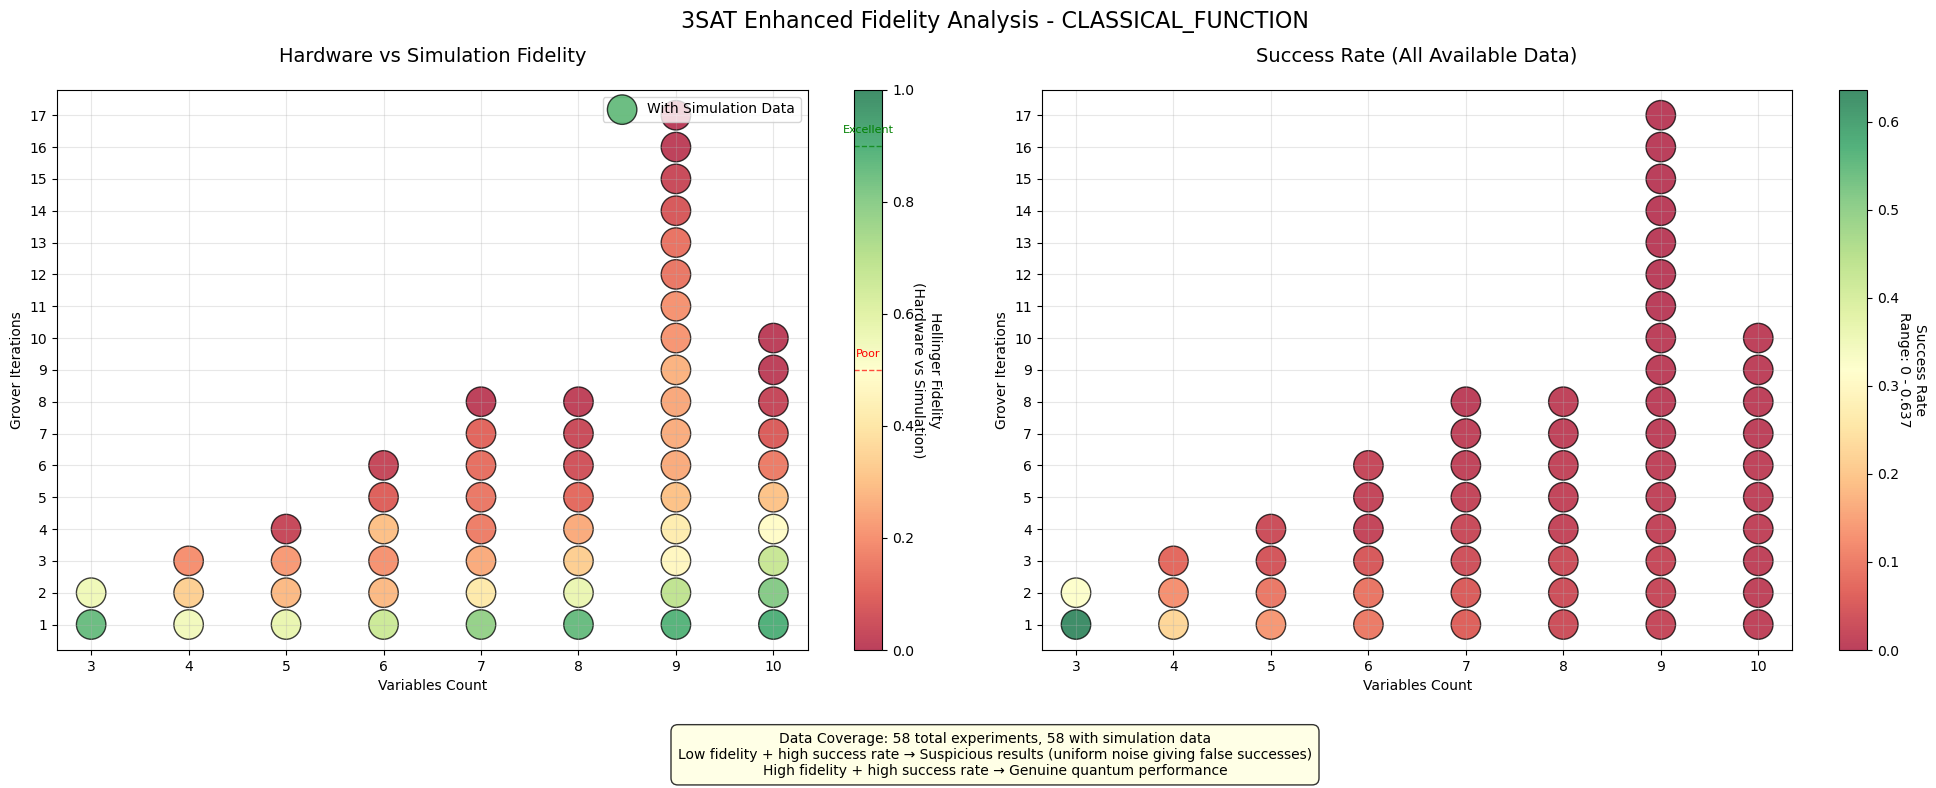


Detailed Analysis for CLASSICAL_FUNCTION:
  Total data points: 58
  Points with simulation data: 58 (100.0%)
  Average success rate (all points): 0.0442
  Average fidelity (sim available): 0.3019


In [4]:
from benchmarklib.analysis import analyze_fidelity
analyze_fidelity(db)

Analyzing quantum advantage for 3SAT problems:
  Total instances: 2400
  Completed trials: 810

n=3 bits, k=1 iterations (16 trials)
  Mean quantum advantage factor: 2.14
  Quantum advantage retained
n=3 bits, k=2 iterations (3 trials)
  Mean quantum advantage factor: 0.93
  Quantum advantage lost
n=4 bits, k=1 iterations (19 trials)
  Mean quantum advantage factor: 1.17
  Quantum advantage retained
n=4 bits, k=2 iterations (8 trials)
  Mean quantum advantage factor: 0.57
  Quantum advantage lost
n=4 bits, k=3 iterations (3 trials)
  Mean quantum advantage factor: 0.36
  Quantum advantage lost
n=5 bits, k=1 iterations (20 trials)
  Mean quantum advantage factor: 1.02
  Quantum advantage retained
n=5 bits, k=2 iterations (12 trials)
  Mean quantum advantage factor: 0.51
  Quantum advantage lost
n=5 bits, k=3 iterations (3 trials)
  Mean quantum advantage factor: 0.32
  Quantum advantage lost
n=5 bits, k=4 iterations (2 trials)
  Mean quantum advantage factor: 0.27
  Quantum advantage lo

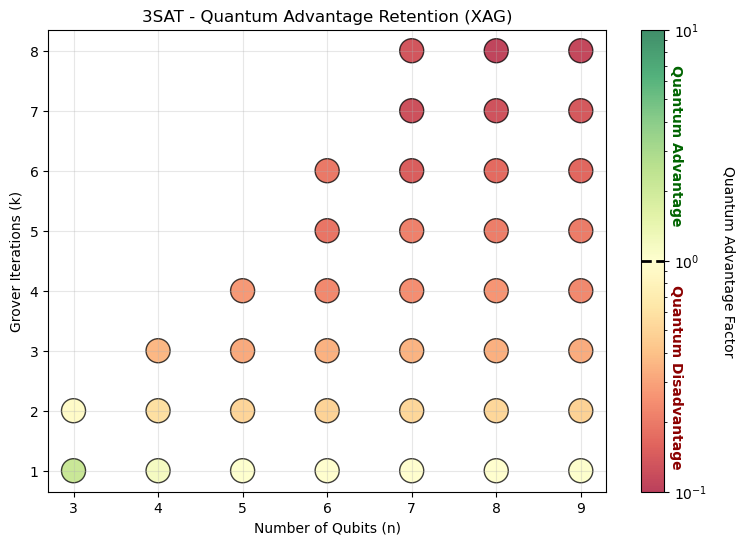

In [6]:
from benchmarklib.analysis import quantum_advantage

quantum_advantage(db1, [CompileType.XAG], "plots")

Analyzing quantum advantage for 3SAT problems:
  Total instances: 2400
  Completed trials: 490

n=3 bits, k=1 iterations (16 trials)
  Mean quantum advantage factor: 1.80
  Quantum advantage retained
n=3 bits, k=2 iterations (2 trials)
  Mean quantum advantage factor: 0.85
  Quantum advantage lost
n=4 bits, k=1 iterations (19 trials)
  Mean quantum advantage factor: 1.30
  Quantum advantage retained
n=4 bits, k=2 iterations (9 trials)
  Mean quantum advantage factor: 0.57
  Quantum advantage lost
n=4 bits, k=3 iterations (3 trials)
  Mean quantum advantage factor: 0.41
  Quantum advantage lost
n=5 bits, k=1 iterations (20 trials)
  Mean quantum advantage factor: 0.98
  Quantum advantage lost
n=5 bits, k=2 iterations (13 trials)
  Mean quantum advantage factor: 0.51
  Quantum advantage lost
n=5 bits, k=3 iterations (2 trials)
  Mean quantum advantage factor: 0.33
  Quantum advantage lost
n=6 bits, k=1 iterations (20 trials)
  Mean quantum advantage factor: 0.98
  Quantum advantage lost


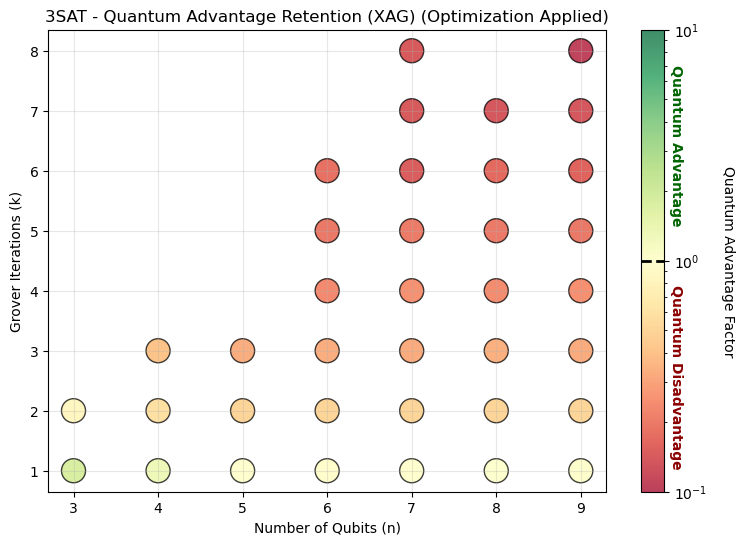

In [4]:

from benchmarklib.analysis import quantum_advantage

quantum_advantage(db2, [CompileType.XAG], "plots", )